In [7]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [10]:
data = pd.read_csv(r"C:\Users\nico_\Desktop\taches_solaires\sunspots.csv",sep=",")

In [12]:
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [15]:
time = np.array(data["Unnamed: 0"])
series = np.array(data["Monthly Mean Total Sunspot Number"])

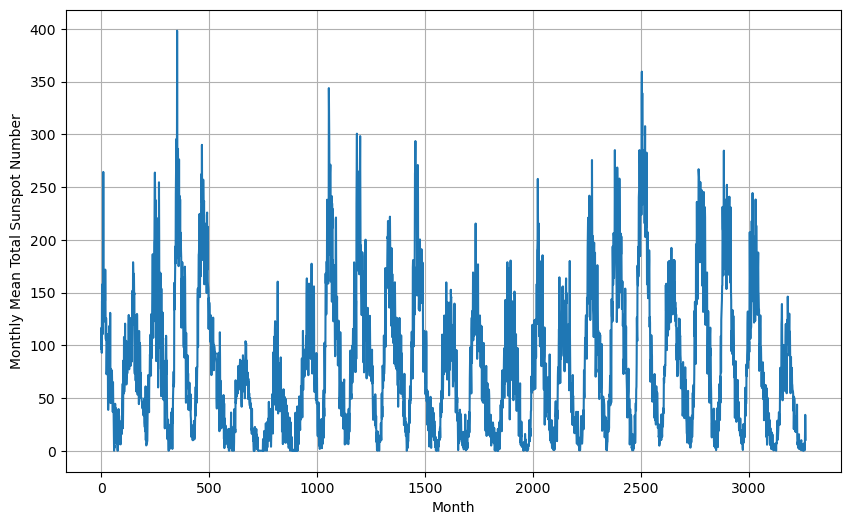

In [18]:
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

In [19]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [21]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1251 (4.89 KB)
Trainable params: 1251 (4.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 2s 5ms/step - loss: 116.1734 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 4ms/step - loss: 115.2277 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 4ms/step - loss: 114.1608 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 5ms/step - loss: 112.9680 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 5ms/step - loss: 111.6340 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 4ms/step - loss: 110.1442 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 0s 4ms/step - loss: 108.4778 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 0s 4ms/step - loss: 106.6129 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 4ms/step - loss: 104.5292 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 4ms/step - loss: 102.1967 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 100.0)

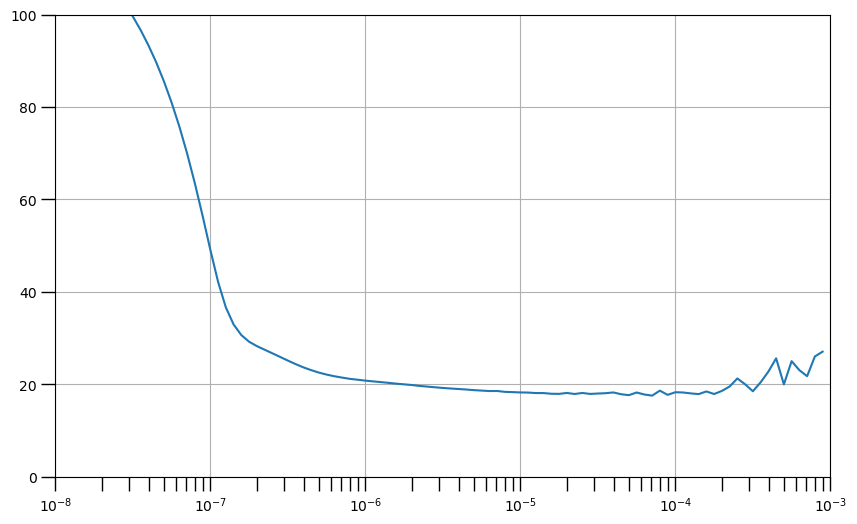

In [24]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))

plt.grid(True)

plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-8, 1e-3, 0, 100])

In [25]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [26]:
learning_rate = 2e-5
 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 2s 7ms/step - loss: 35.9280 - mae: 36.4225
Epoch 2/100
93/93 [==============================] - 1s 4ms/step - loss: 21.3499 - mae: 21.8431
Epoch 3/100
93/93 [==============================] - 1s 4ms/step - loss: 20.1390 - mae: 20.6320
Epoch 4/100
93/93 [==============================] - 1s 4ms/step - loss: 20.0363 - mae: 20.5299
Epoch 5/100
93/93 [==============================] - 1s 4ms/step - loss: 18.7606 - mae: 19.2521
Epoch 6/100
93/93 [==============================] - 1s 5ms/step - loss: 18.5221 - mae: 19.0136
Epoch 7/100
93/93 [==============================] - 1s 4ms/step - loss: 18.3877 - mae: 18.8804
Epoch 8/100
93/93 [==============================] - 1s 4ms/step - loss: 18.1644 - mae: 18.6559
Epoch 9/100
93/93 [==============================] - 1s 4ms/step - loss: 17.9512 - mae: 18.4430
Epoch 10/100
93/93 [==============================] - 1s 4ms/step - loss: 17.8551 - mae: 18.3450
Epoch 11/100
93/93 [===================

In [27]:
def model_forecast(model, series, window_size, batch_size):

    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    dataset = dataset.flat_map(lambda w: w.batch(window_size))
  
    dataset = dataset.batch(batch_size).prefetch(1)
 
    forecast = model.predict(dataset)
    
    return forecast

9/9 [==============================] - 0s 7ms/step


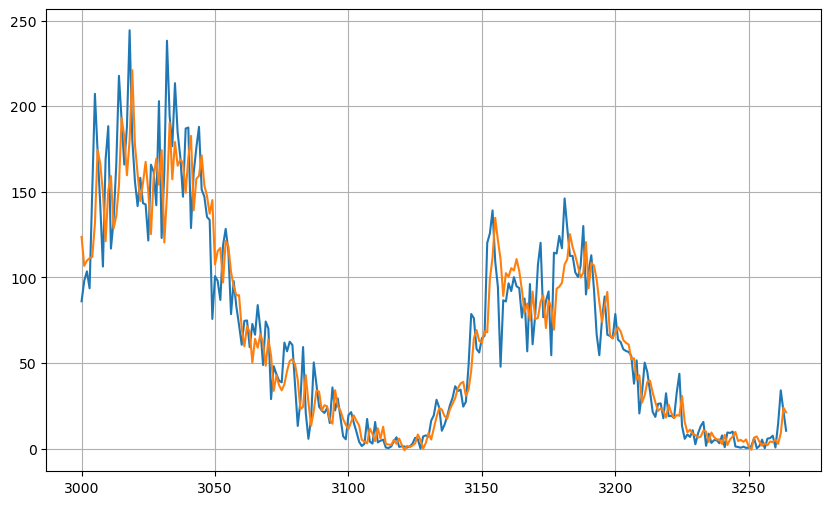

In [28]:
forecast_series = series[split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [29]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

13.951619


# Couches combinées

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding="causal",
                          input_shape = [window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                

In [31]:
init_weights = model.get_weights()

In [32]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 9s 30ms/step - loss: 92.9268 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 3s 31ms/step - loss: 71.7968 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 3s 30ms/step - loss: 59.4627 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 3s 29ms/step - loss: 49.9534 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 3s 28ms/step - loss: 43.7604 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 3s 28ms/step - loss: 39.5541 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 3s 30ms/step - loss: 36.2307 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 3s 32ms/step - loss: 33.8373 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 3s 29ms/step - loss: 31.9204 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 3s 31ms/step - loss: 30.1701 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 100.0)

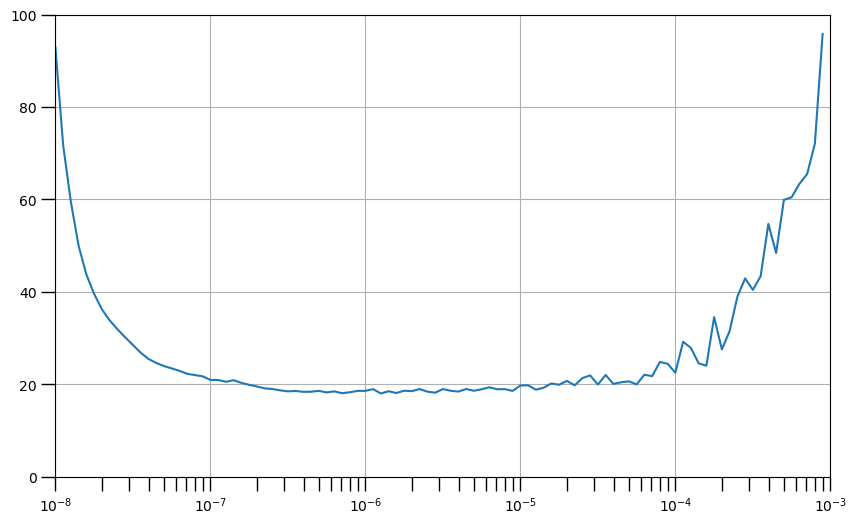

In [33]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))

plt.grid(True)

plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-8, 1e-3, 0, 100])

In [34]:
tf.keras.backend.clear_session()

model.set_weights(init_weights)

In [35]:
learning_rate = 8e-7
 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [36]:
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 9s 29ms/step - loss: 36.1617 - mae: 36.6581
Epoch 2/100
93/93 [==============================] - 3s 28ms/step - loss: 21.5088 - mae: 22.0008
Epoch 3/100
93/93 [==============================] - 3s 29ms/step - loss: 21.0296 - mae: 21.5235
Epoch 4/100
93/93 [==============================] - 3s 30ms/step - loss: 20.4037 - mae: 20.8971
Epoch 5/100
93/93 [==============================] - 3s 29ms/step - loss: 19.2417 - mae: 19.7329
Epoch 6/100
93/93 [==============================] - 3s 28ms/step - loss: 18.8448 - mae: 19.3364
Epoch 7/100
93/93 [==============================] - 3s 28ms/step - loss: 18.8186 - mae: 19.3101
Epoch 8/100
93/93 [==============================] - 3s 28ms/step - loss: 19.1159 - mae: 19.6070
Epoch 9/100
93/93 [==============================] - 3s 31ms/step - loss: 18.5797 - mae: 19.0711
Epoch 10/100
93/93 [==============================] - 3s 31ms/step - loss: 18.1873 - mae: 18.6774
Epoch 11/100
93/93 [=========

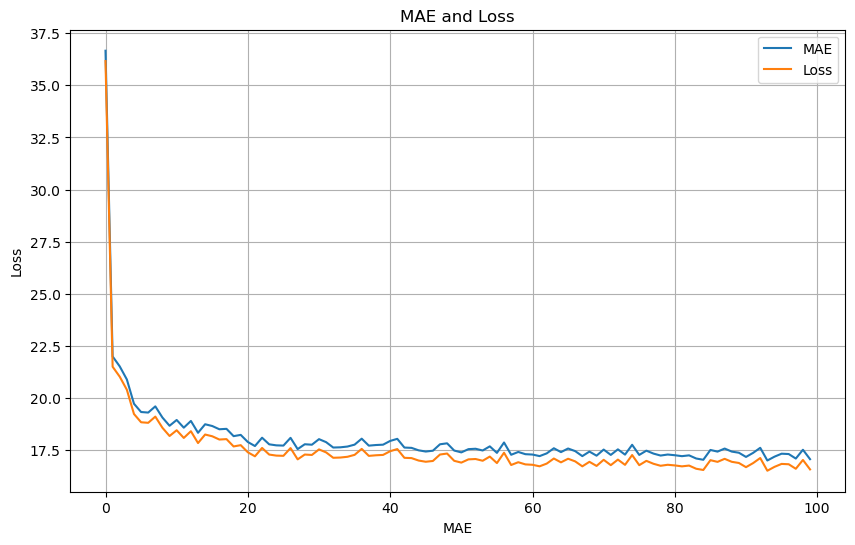

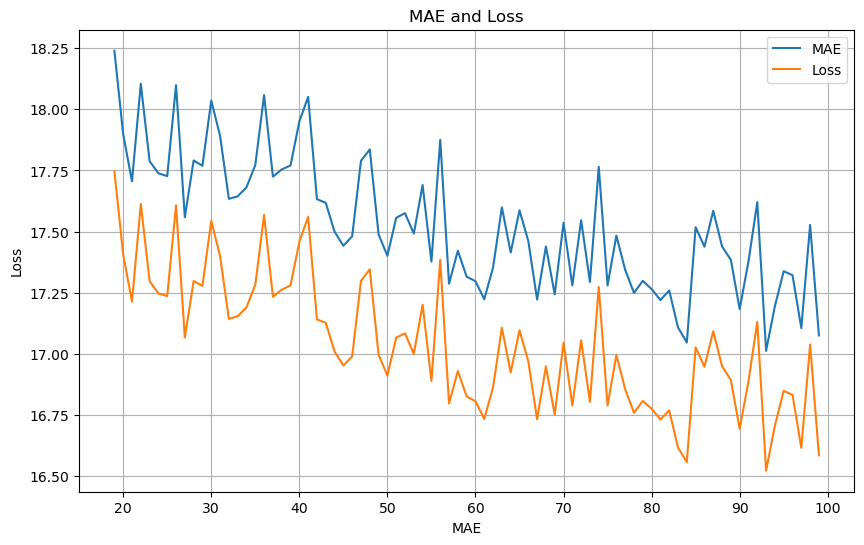

In [37]:
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) 

# mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [38]:
def model_forecast(model, series, window_size, batch_size):
  
    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    dataset = dataset.flat_map(lambda w: w.batch(window_size))
 
    dataset = dataset.batch(batch_size).prefetch(1)

    forecast = model.predict(dataset)
    
    return forecast

9/9 [==============================] - 1s 16ms/step


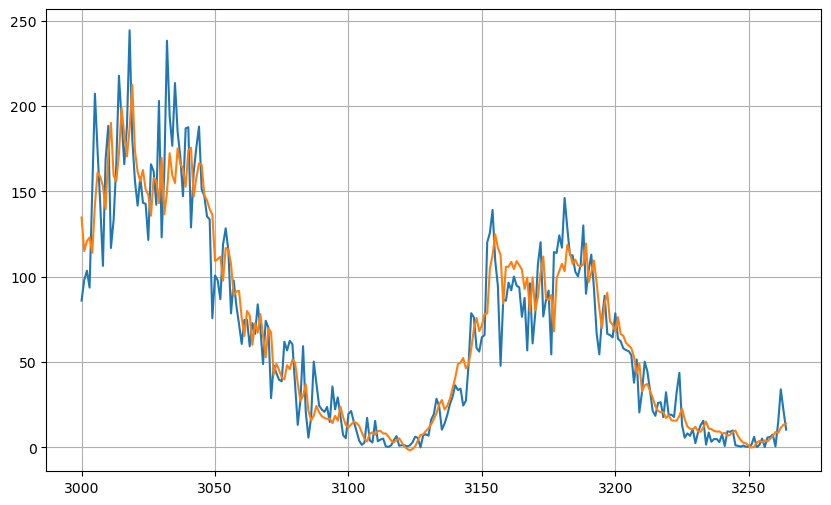

In [39]:
forecast_series = series[split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [40]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

13.567564
